In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import sys
import os

dev = False  # Set to false when using production version of library
if dev:
    # Path to Dev version of autots library
    sys.path.append(os.environ["DEV_AUTOTS"])
    %load_ext autoreload
    %autoreload 2

from auto_ts import auto_timeseries

Importing plotly failed. Interactive plots will not work.


Imported auto_timeseries version:0.0.37. Call by using:
model = auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],
                verbose=2)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



# Load Dataset

In [3]:
file_path = (
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
)
dataset = pd.read_csv(file_path, engine="python")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
dataset.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<AxesSubplot:>

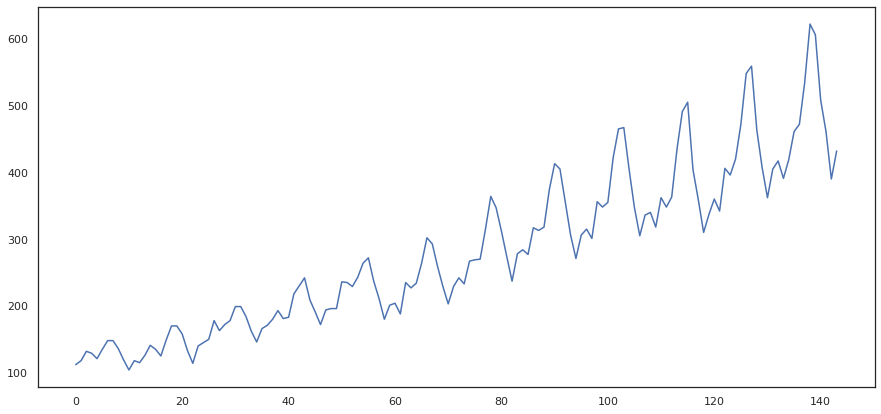

In [5]:
dataset["Passengers"].plot(figsize=(15, 7))

In [6]:
dataset = dataset.set_index(pd.to_datetime(dataset.pop("Month")))
dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [7]:
dataset = dataset.resample("QS").sum()

In [8]:
dataset = dataset.reset_index()
dataset.head()

,Month,Passengers
0,1949-01-01,362
1,1949-04-01,385
2,1949-07-01,432
3,1949-10-01,341
4,1950-01-01,382


# Train Model

In [9]:
ts_column = "Month"
target = "Passengers"
sep = ","

In [10]:
FORECAST_PERIOD = 2

In [11]:
model = auto_timeseries(
    score_type="rmse",
    time_interval="QS",
    non_seasonal_pdq=None,
    seasonality=False,
    seasonal_period=12,
    model_type=["prophet"],
    verbose=2,
)

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Error: Stationary test failed. Data must be np.array. Check your input and try stationary test again
    Target variable given as = Passengers
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_column: Month sep: , target: Passengers
    Loaded pandas dataframe...
    pandas Dataframe loaded successfully. Shape of data set = (48, 1)


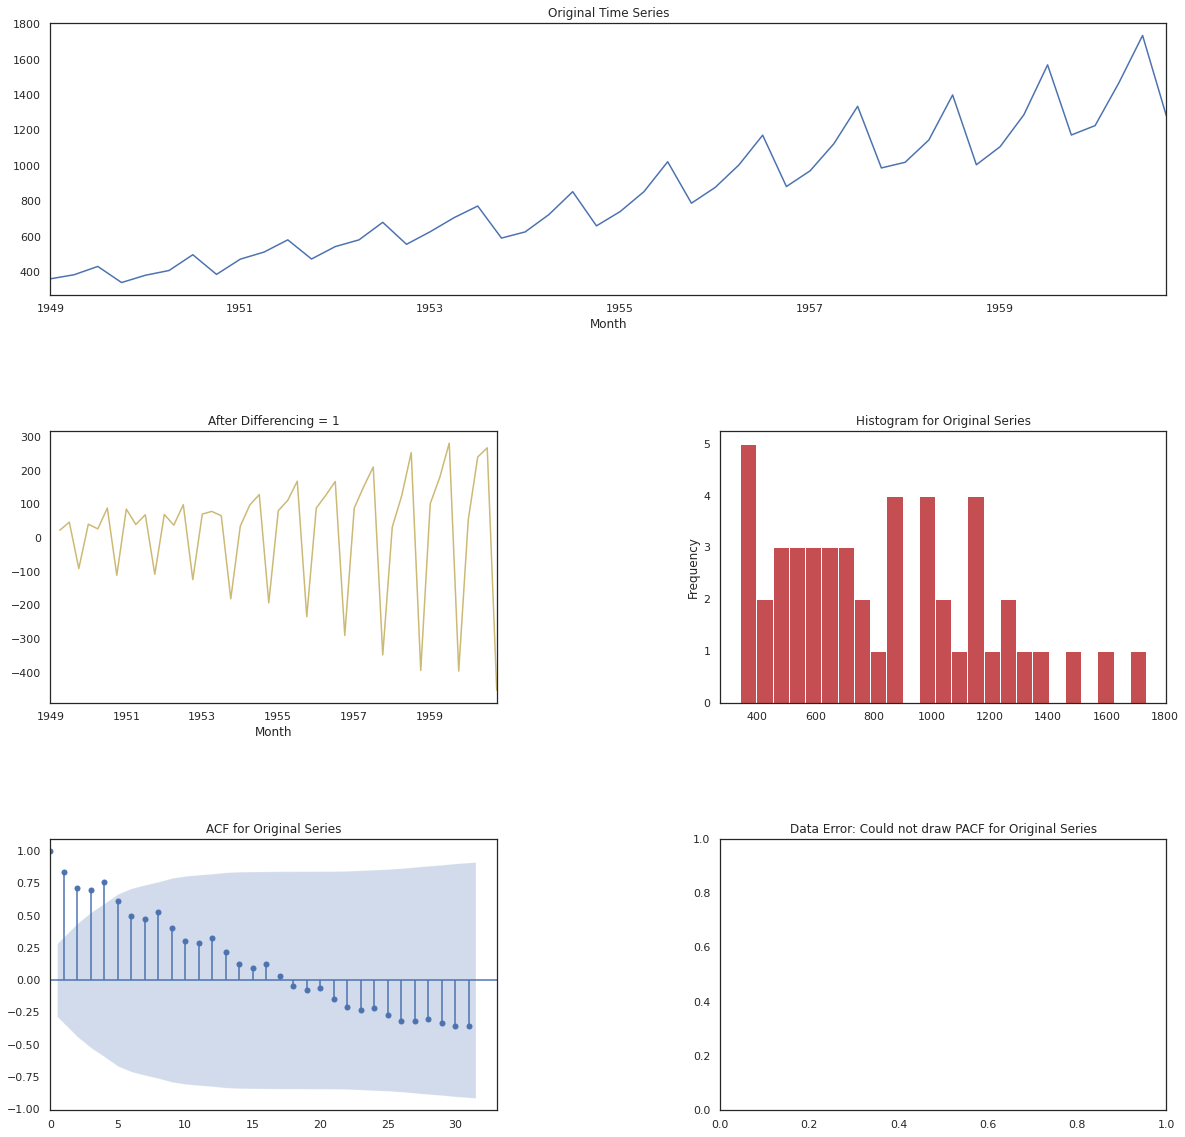

Time Interval is given as QS
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(48, 2)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 3

Fold Number: 1 --> Train Shape: 33 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 87.05
    Std Deviation of actuals = 122.26
    Normalized RMSE = 71%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 38 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 118.55
    Std Deviation of actuals = 201.53
    Normalized RMSE = 59%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 43 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 102.20
    Std Deviation of actuals = 204.80
    Nor

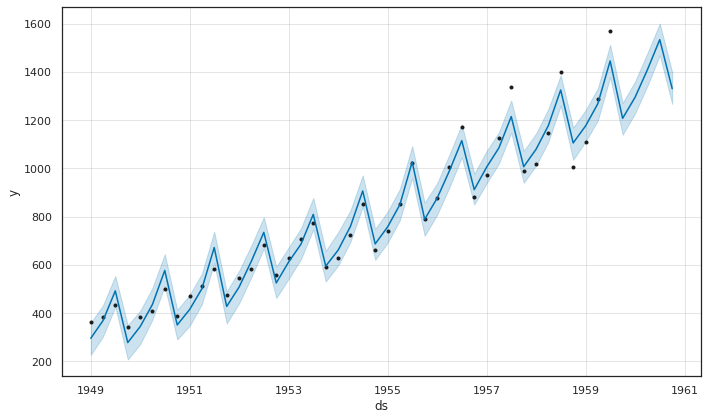

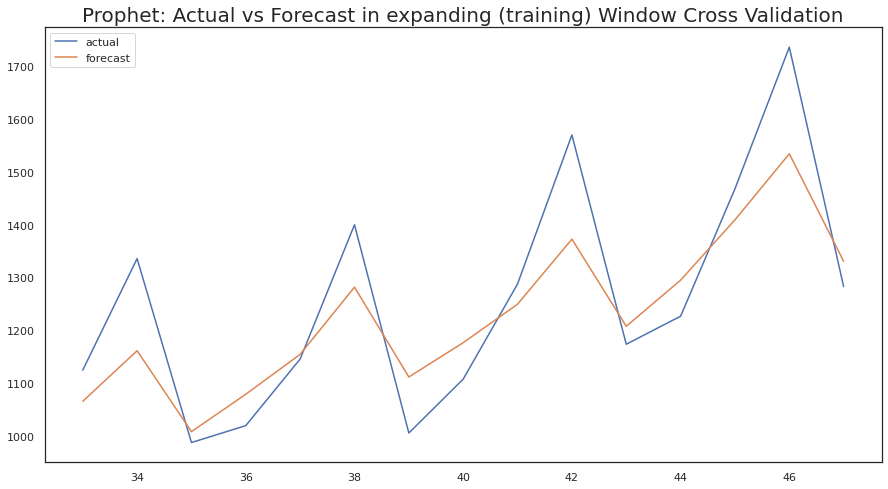

In [12]:
model.fit(
    traindata=dataset,
    # traindata=file_path,  # Alternately, you can specify the file directly
    ts_column=ts_column,
    target=target,
    cv=3,
    sep=sep,
)

# Evaluate Results

In [13]:
model.get_leaderboard()

,name,rmse
0,Prophet,102.598272


<AxesSubplot:xlabel='Model', ylabel='CV Scores'>

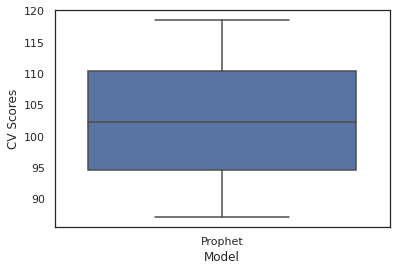

In [14]:
model.plot_cv_scores()

In [15]:
# Make sure all models have the same number of CV folds
model.get_cv_scores()

,Model,CV Scores
0,Prophet,87.046287
1,Prophet,118.549995
2,Prophet,102.198534


In [16]:
results_dict = model.get_ml_dict()

In [17]:
results_dict["Prophet"]["forecast"]

array([1065.92976775, 1161.73671128, 1008.60570975, 1079.37869573,
       1154.82436038, 1281.92964327, 1111.99496836, 1176.9010274 ,
       1249.75309589, 1372.80774161, 1207.94421838, 1295.20025005,
       1409.35438975, 1534.28943881, 1330.88276452])

In [18]:
# results_dict['auto_SARIMAX']['forecast']

In [19]:
# results_dict['ML']['forecast']

In [20]:
dataset.tail()

,Month,Passengers
43,1959-10-01,1174
44,1960-01-01,1227
45,1960-04-01,1468
46,1960-07-01,1736
47,1960-10-01,1283


# Forecast Results

In [21]:
# Using Best Model
future_predictions = model.predict(testdata=FORECAST_PERIOD)
future_predictions

Building Forecast dataframe. Forecast Period = 2


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
48,1961-01-01,4351.438223,1371.553926,1508.831862,4351.344817,4351.536271,-2910.721605,-2910.721605,-2910.721605,-2910.721605,-2910.721605,-2910.721605,0.0,0.0,0.0,1440.716618
49,1961-04-01,4377.810167,1448.170275,1590.042298,4377.395751,4378.224501,-2855.307228,-2855.307228,-2855.307228,-2855.307228,-2855.307228,-2855.307228,0.0,0.0,0.0,1522.502939


In [22]:
# Using specific model
future_predictions = model.predict(testdata=FORECAST_PERIOD, model="auto_SARIMAX")
future_predictions

Model with name 'auto_SARIMAX' does not exist.
(Error) Model of type 'auto_SARIMAX' does not exist. No predictions will be made.


In [23]:
# Using specific model
future_predictions = model.predict(
    testdata=FORECAST_PERIOD, model="Prophet", simple=False
)
future_predictions

Building Forecast dataframe. Forecast Period = 2


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
48,1961-01-01,4351.438223,1370.308556,1509.983660,4351.328576,4351.510457,-2910.721605,-2910.721605,-2910.721605,-2910.721605,-2910.721605,-2910.721605,0.0,0.0,0.0,1440.716618
49,1961-04-01,4377.810167,1450.864802,1593.031873,4377.377596,4378.197670,-2855.307228,-2855.307228,-2855.307228,-2855.307228,-2855.307228,-2855.307228,0.0,0.0,0.0,1522.502939
